## CREDIT CARD FRAUD

## DATASET - Normalised

Firstly we need to import the necessary libraries and configure the Spark session. 

In [1]:
#Import libraries and configure spark session
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
from scipy import stats
from scipy.stats import norm
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
# df1_new dataset to be used
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

import pyspark.sql.functions as f
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("xpto") \
    .getOrCreate()
sc = spark.sparkContext

## Load Dataset

In [2]:
# Load file
dfscaled = spark.read.csv('dfscaled.csv', header=True, inferSchema=True, sep=",")

# Print Schema
dfscaled.printSchema()

root
 |-- Class: integer (nullable = true)
 |-- Time_Scaled: double (nullable = true)
 |-- V1_Scaled: double (nullable = true)
 |-- V2_Scaled: double (nullable = true)
 |-- V3_Scaled: double (nullable = true)
 |-- V4_Scaled: double (nullable = true)
 |-- V5_Scaled: double (nullable = true)
 |-- V6_Scaled: double (nullable = true)
 |-- V7_Scaled: double (nullable = true)
 |-- V8_Scaled: double (nullable = true)
 |-- V9_Scaled: double (nullable = true)
 |-- V10_Scaled: double (nullable = true)
 |-- V11_Scaled: double (nullable = true)
 |-- V12_Scaled: double (nullable = true)
 |-- V13_Scaled: double (nullable = true)
 |-- V14_Scaled: double (nullable = true)
 |-- V15_Scaled: double (nullable = true)
 |-- V16_Scaled: double (nullable = true)
 |-- V17_Scaled: double (nullable = true)
 |-- V18_Scaled: double (nullable = true)
 |-- V19_Scaled: double (nullable = true)
 |-- V20_Scaled: double (nullable = true)
 |-- V21_Scaled: double (nullable = true)
 |-- V22_Scaled: double (nullable = true)

## Distribution of fraud transactions - Plotting

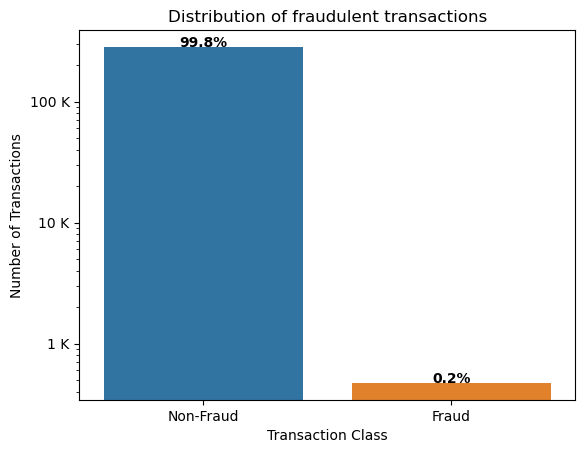

In [3]:
fraud_df = dfscaled.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}%", ha='center', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Distribution of fraudulent transactions')

plt.show()

## IMBALANCED DATA -> BALANCED DATA

In [4]:
dfbalance= dfscaled.toPandas()

In [5]:
# amount of fraud classes 492 rows.
fraud_df = dfbalance.loc[dfbalance['Class'] == 1]
non_fraud_df = dfbalance.loc[dfbalance['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
dfbalance = normal_distributed_df.sample(frac=1, random_state=42)


dfbalance.shape

(965, 31)

Distribution of the Classes in the subsample dataset
0    0.509845
1    0.490155
Name: Class, dtype: float64


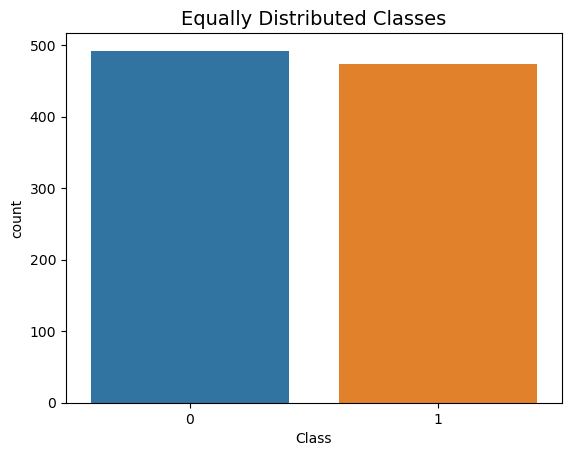

In [6]:
#Plot Distribution of the Classes
print('Distribution of the Classes in the subsample dataset')
print(dfbalance['Class'].value_counts()/len(dfbalance))

sns.countplot(x ='Class', data=dfbalance)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Features Selection

### Benefits of performing feature selection
Reduce Overfitting: Less redundant data means less opportunity to make decision based on irrelevant data(noise).\
Improves Model Performance: Less misleading data means our model’s performance is improves.\
Reduce Training Time: Less data means algorithm train faster.

## Using Balance Dataset - Sklearn functions

## Correlation Coefficient Method

Correlation is a measure of the linear relationship between 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that good variables correlate highly with the target. Furthermore, variables should be correlated with the target but uncorrelated among themselves.

If two variables are correlated, we can predict one from the other. Therefore, if two features are correlated, the model only needs one, as the second does not add additional information. We will use the Pearson Correlation here.

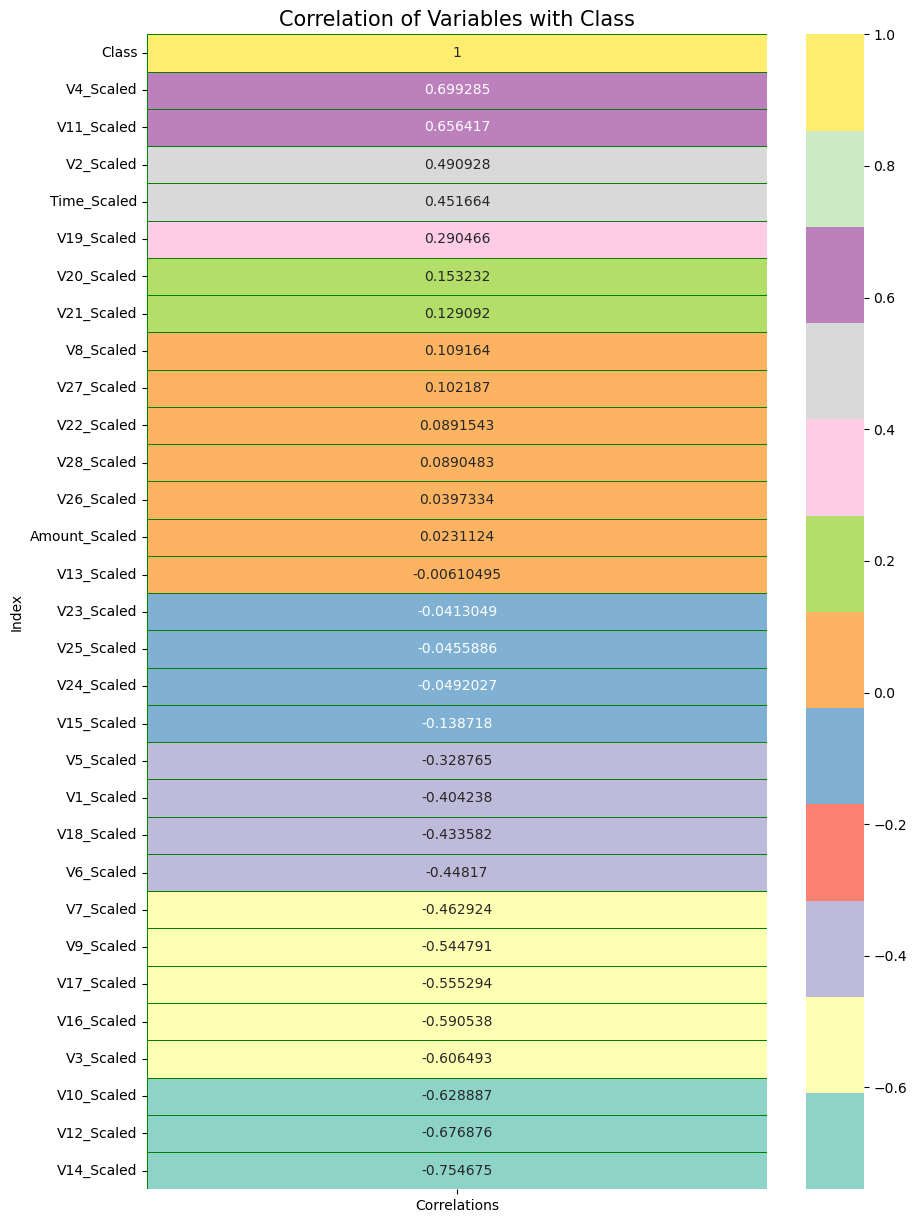

In [35]:
#df_balance = df_balance.toPandas()

#df_balance =df_balance.drop(['Time_Scaled'],axis = 1)

corr = dfbalance.corrwith(dfbalance['Class'],method='pearson').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(31)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlation of Variables with Class", fontsize=15)
plt.show()

##  Kbest Select with F_Classif Method

Select features according to the k highest scores.

In [8]:
X = dfbalance.drop(['Class'],axis = 1)
Y = dfbalance['Class'] # target
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state = 42)

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif
bestfeatures = SelectKBest(score_func=f_classif, k=29)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(6,'Score'))  


       Feature        Score
14  V14_Scaled  1274.112294
4    V4_Scaled   921.536530
12  V12_Scaled   814.280986
11  V11_Scaled   729.097722
10  V10_Scaled   630.048714
3    V3_Scaled   560.334064


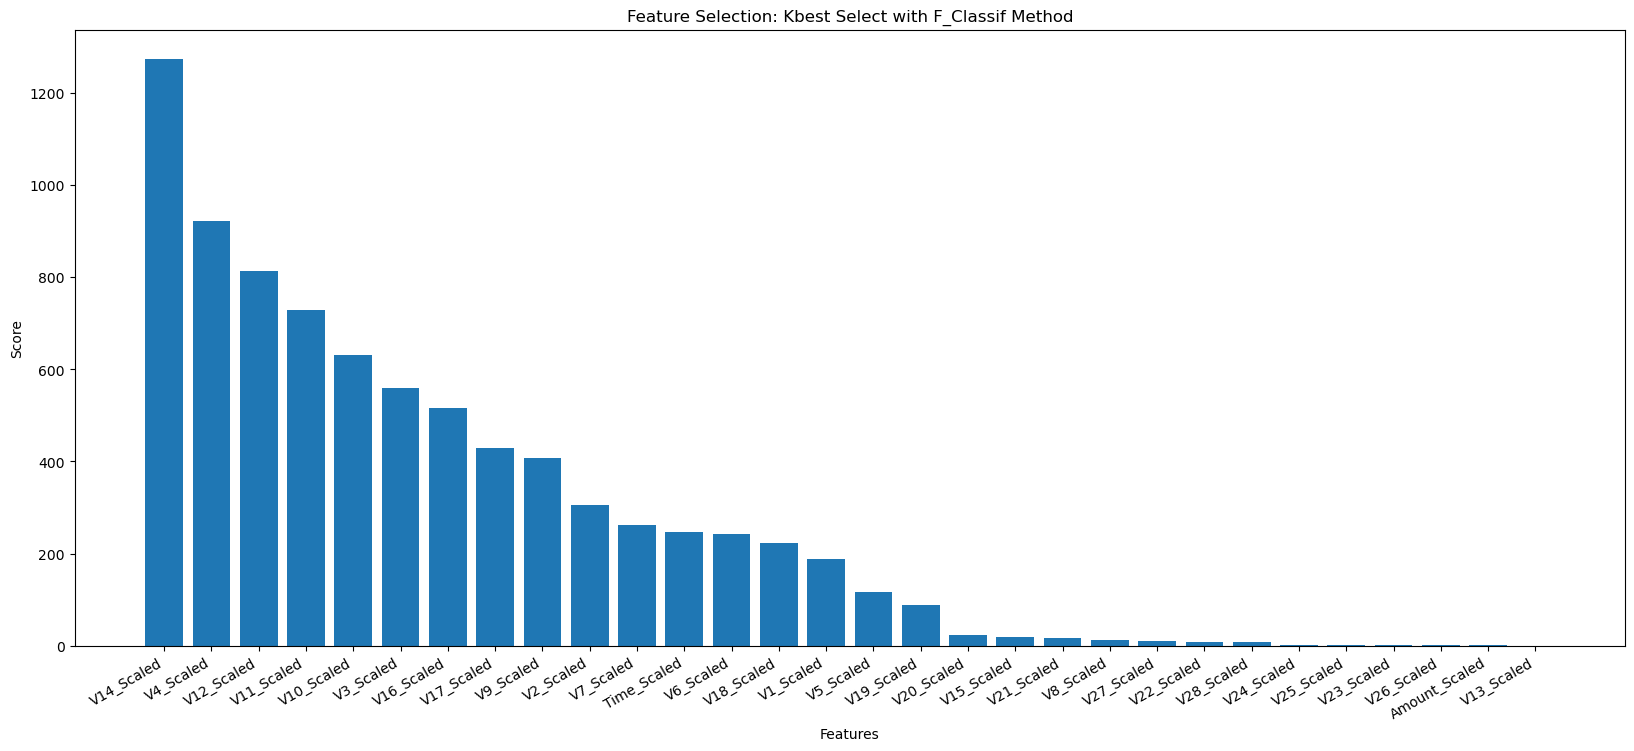

In [10]:
plt.figure(figsize=(20,8))
featureScores2 = featureScores.sort_values('Score', ascending=False)
plt.bar("Feature", "Score", data=featureScores2)
plt.xticks(rotation=30, ha='right')
plt.title('Feature Selection: Kbest Select with F_Classif Method')
plt.ylabel('Score')
plt.xlabel('Features')
plt.show()


## KBest with Mutual Information Classification Method

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [11]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=29)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
feature_score3 = pd.concat([dfcolumns,dfscores],axis=1)
feature_score3.columns = ['Feature','Score'] 
print(feature_score3.nlargest(6,'Score'))  


       Feature     Score
14  V14_Scaled  0.490318
3    V3_Scaled  0.460754
17  V17_Scaled  0.455662
10  V10_Scaled  0.437185
12  V12_Scaled  0.401442
4    V4_Scaled  0.371662


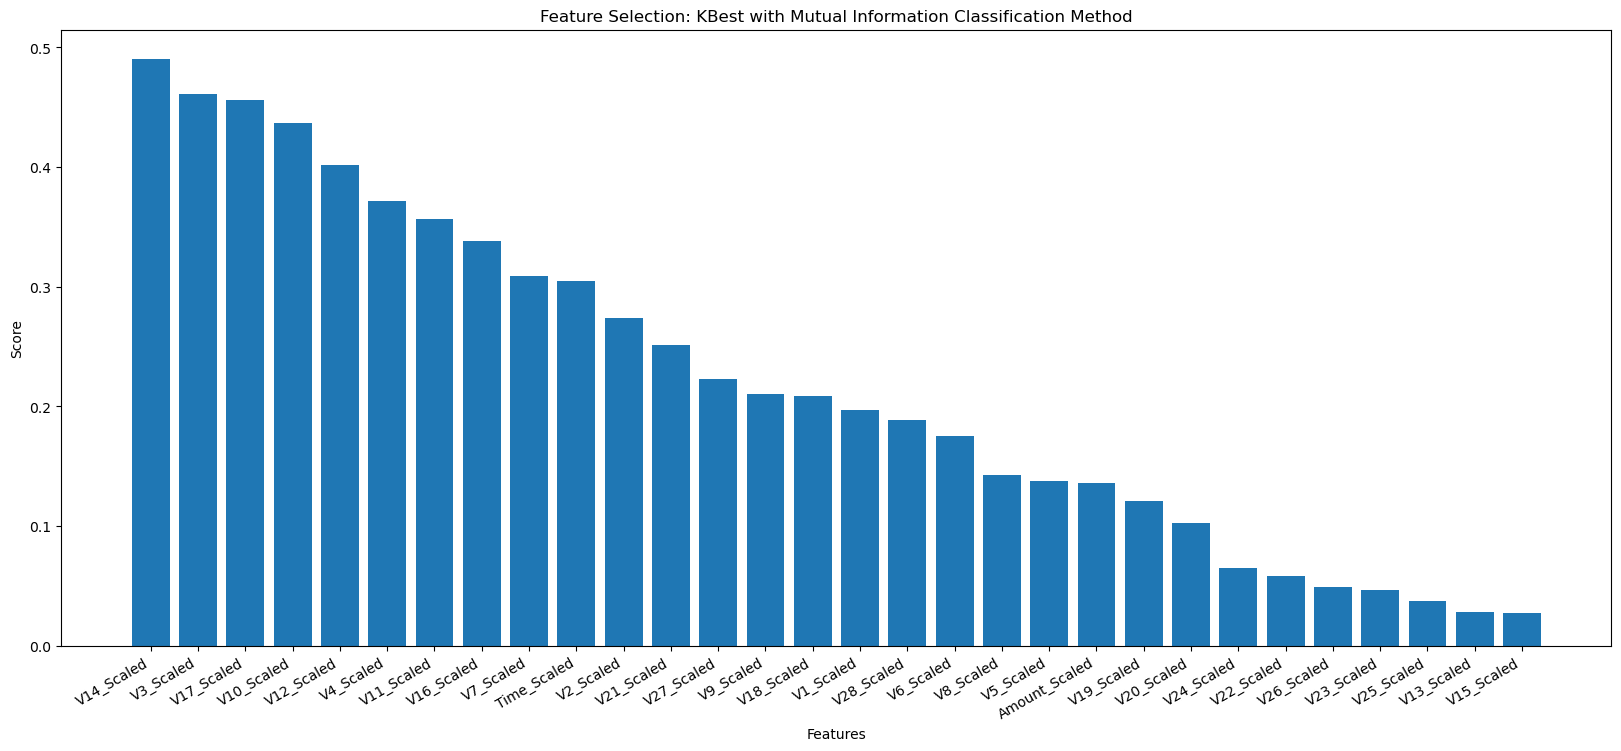

In [12]:
plt.figure(figsize=(20,8))
feature_score3 = feature_score3.sort_values('Score', ascending=False)
plt.bar("Feature", "Score", data=feature_score3)
plt.xticks(rotation=30, ha='right')
plt.title('Feature Selection: KBest with Mutual Information Classification Method')
plt.ylabel('Score')
plt.xlabel('Features')
plt.show()

## Observations Sklearn function:

Based on our analysis, we can conclude that features V14, V12, V10 and V3 have a higher potential to explain whether a fraud may occur or not. These variables could play a crucial role in identifying potential fraud and help prevent it. 
_______________________________________________________________________________________

## Feature Importance Score - Pyspark function

Feature Importance score here means any score generated from the trained model representing the weight or relevancy of the features to the prediction of the target feature.

The common theme of the problems is that when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance.

In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality.

Also, organizing and searching data often relies on detecting areas where objects form groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data organization strategies from being efficient.

Several models are used for feature selection:Correlation or chi-square, Stepwise method, Lasso - Penalized likelihood,PCA and Input Perturbation.

Input Perturbation algorithm was introduced by Breiman in his seminal paper on random forests. Although he presented this algorithm in conjunction with random forests, it is model-independent and appropriate for any supervised learning model.




## Train and test data split df

In [13]:
from pyspark.sql.functions import lit
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorSlicer

### Stratified split
Here I used stratified split instead of random split which can overcome the imblance data problem.

In [14]:
dfbalance2 = spark.createDataFrame(dfbalance)
dfbalance2.printSchema()

root
 |-- Class: long (nullable = true)
 |-- Time_Scaled: double (nullable = true)
 |-- V1_Scaled: double (nullable = true)
 |-- V2_Scaled: double (nullable = true)
 |-- V3_Scaled: double (nullable = true)
 |-- V4_Scaled: double (nullable = true)
 |-- V5_Scaled: double (nullable = true)
 |-- V6_Scaled: double (nullable = true)
 |-- V7_Scaled: double (nullable = true)
 |-- V8_Scaled: double (nullable = true)
 |-- V9_Scaled: double (nullable = true)
 |-- V10_Scaled: double (nullable = true)
 |-- V11_Scaled: double (nullable = true)
 |-- V12_Scaled: double (nullable = true)
 |-- V13_Scaled: double (nullable = true)
 |-- V14_Scaled: double (nullable = true)
 |-- V15_Scaled: double (nullable = true)
 |-- V16_Scaled: double (nullable = true)
 |-- V17_Scaled: double (nullable = true)
 |-- V18_Scaled: double (nullable = true)
 |-- V19_Scaled: double (nullable = true)
 |-- V20_Scaled: double (nullable = true)
 |-- V21_Scaled: double (nullable = true)
 |-- V22_Scaled: double (nullable = true)
 |

In [15]:
fractions =dfbalance2.select("Class").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
df_train = dfbalance2.sampleBy('Class',fractions,seed=42)
df_test = dfbalance2.subtract(df_train)

In [16]:
df_train.head()

Row(Class=0, Time_Scaled=-0.684, V1_Scaled=-0.355, V2_Scaled=0.601, V3_Scaled=1.086, V4_Scaled=0.004, V5_Scaled=0.032, V6_Scaled=-0.483, V7_Scaled=0.512, V8_Scaled=-0.006, V9_Scaled=-0.373, V10_Scaled=-0.234, V11_Scaled=0.191, V12_Scaled=0.369, V13_Scaled=0.383, V14_Scaled=0.071, V15_Scaled=1.14, V16_Scaled=-0.25, V17_Scaled=-0.036, V18_Scaled=-1.152, V19_Scaled=-0.562, V20_Scaled=0.064, V21_Scaled=-0.226, V22_Scaled=-0.52, V23_Scaled=0.233, V24_Scaled=0.643, V25_Scaled=-0.544, V26_Scaled=0.146, V27_Scaled=0.407, V28_Scaled=0.33, Amount_Scaled=-0.345)

## Model - pipeline

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator,  TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [18]:
yv = ['Class']
xv = ['V1_Scaled','V2_Scaled','V3_Scaled','V4_Scaled',
      'V5_Scaled','V6_Scaled','V7_Scaled','V8_Scaled', 'V9_Scaled','V10_Scaled',
      'V11_Scaled','V12_Scaled','V13_Scaled','V14_Scaled', 'V15_Scaled','V16_Scaled','V17_Scaled','V18_Scaled',
      'V19_Scaled','V20_Scaled','V21_Scaled','V22_Scaled', 'V23_Scaled','V24_Scaled',
      'V25_Scaled','V26_Scaled','V27_Scaled','V28_Scaled','Amount_Scaled', 'Time_Scaled']

### Convert dataframe to vector

In [19]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols= xv, outputCol="features")

### Create a Random Forest Classifier

In [20]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Class", featuresCol="features")

### Creating a Multiclass Classification Evaluator

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()  

### Creating a Pipeline

This will be easier when we need to test different scenarios.

In [22]:
from pyspark.ml import Pipeline
import pandas as pd
##NO pca
pipeline = Pipeline(stages=[vecAssembler, rf])

## Feature Selection - Feature importance method

In [23]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [24]:
mod = pipeline.fit(df_train)

In [25]:
pred_train = mod.transform(df_train) ##get the predicted train values

In [26]:
mod.stages[-1].featureImportances

SparseVector(30, {0: 0.0072, 1: 0.0023, 2: 0.1777, 3: 0.0856, 4: 0.0023, 5: 0.0019, 6: 0.0087, 7: 0.0103, 8: 0.0042, 9: 0.1391, 10: 0.0658, 11: 0.0768, 12: 0.0024, 13: 0.2249, 14: 0.0012, 15: 0.0849, 16: 0.0109, 17: 0.0026, 18: 0.0029, 19: 0.0094, 20: 0.005, 21: 0.002, 22: 0.0015, 23: 0.0011, 24: 0.002, 26: 0.0026, 27: 0.0046, 28: 0.0012, 29: 0.059})

In [27]:
#ExtractFeatureImp(mod.stages[-1].featureImportances, pred_train, "features").head(30)

In [28]:
Feature_Imp=ExtractFeatureImp(mod.stages[-1].featureImportances, pred_train, "features").head(29)
Feature_Imp.head(6)

,idx,name,score
13,13,V14_Scaled,0.224940
2,2,V3_Scaled,0.177743
9,9,V10_Scaled,0.139097
3,3,V4_Scaled,0.085556
15,15,V16_Scaled,0.084878
11,11,V12_Scaled,0.076842


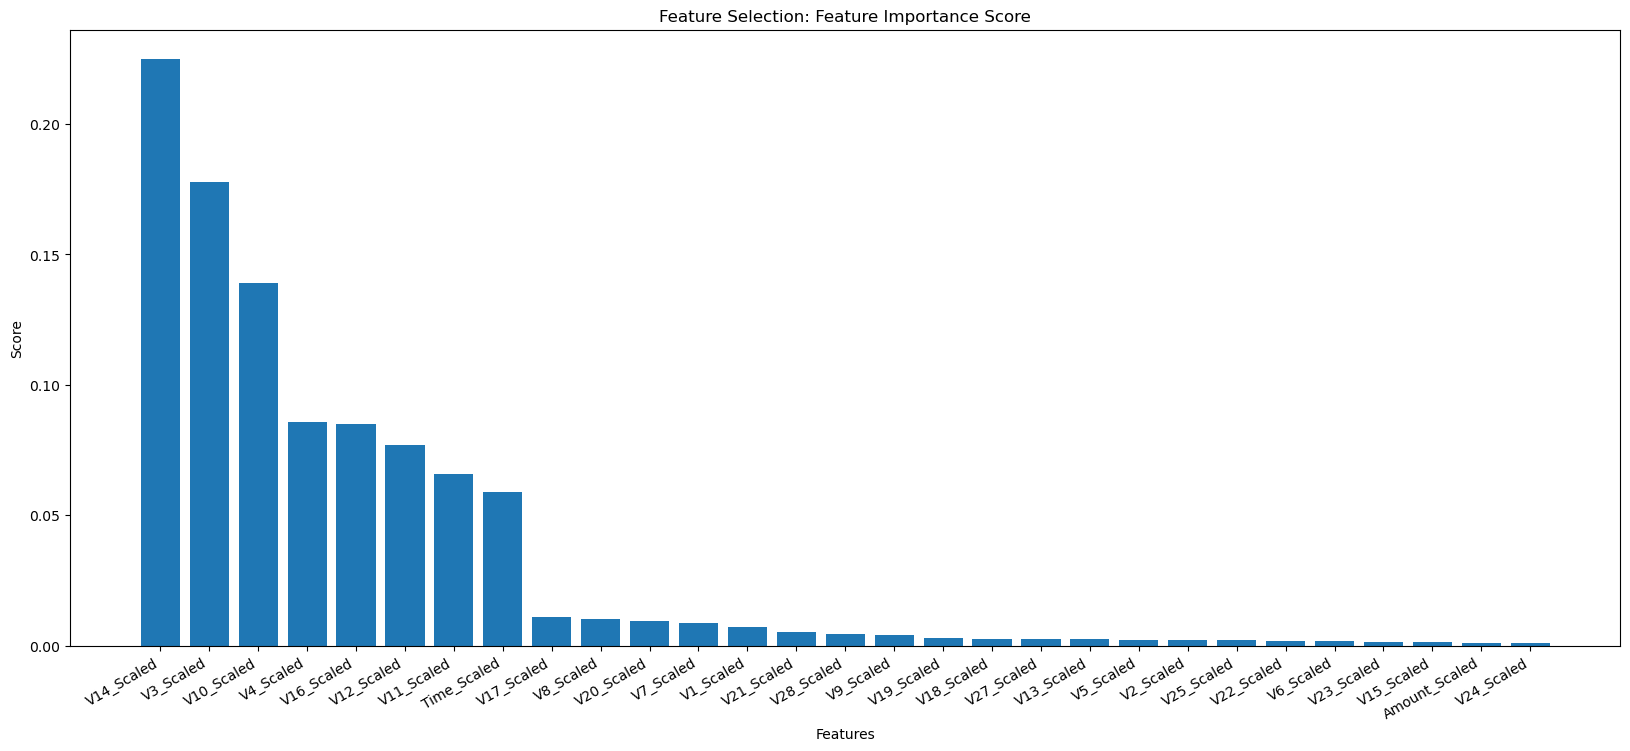

In [29]:
plt.figure(figsize=(20,8))
#Feature_Imp = Feature_Imp.sort_values('Score', ascending=False)
plt.bar("name", "score", data=Feature_Imp)
plt.xticks(rotation=30, ha='right')
plt.title('Feature Selection: Feature Importance Score')
plt.ylabel('Score')
plt.xlabel('Features')
plt.show()

In [30]:
num_feas = 6

In [31]:
varlist = ExtractFeatureImp(mod.stages[-1].featureImportances, pred_train, "features")
varidx = [i for i in varlist['idx'][0:num_feas]]

## Observations Pyspark Function:

Based on our analysis, we can conclude that features V14, V10, V16 and V3 have a higher potential to explain whether a fraud may occur or not. These variables could play a crucial role in identifying potential fraud and help prevent it. 

## Overall Observations:
Six features with higher score: As main conclusion V14, V12, V10 and V3 are selected by the four methods used; V4 by three methods used; V11 and V16 is select two methods used.
_______________________________________________________________________________________

## Used important varaibles for modelling

This method could be used to selected the important features.

In [32]:
slicer = VectorSlicer(inputCol="features", outputCol="features2", indices=varidx)
train_input = slicer.transform(pred_train)

In [33]:
pred_train.limit(3).toPandas()

,Class,Time_Scaled,V1_Scaled,V2_Scaled,V3_Scaled,V4_Scaled,V5_Scaled,V6_Scaled,V7_Scaled,V8_Scaled,...,V24_Scaled,V25_Scaled,V26_Scaled,V27_Scaled,V28_Scaled,Amount_Scaled,features,rawPrediction,probability,prediction
0,0,-0.684,-0.355,0.601,1.086,0.004,0.032,-0.483,0.512,-0.006,...,0.643,-0.544,0.146,0.407,0.330,-0.345,"[-0.355, 0.601, 1.086, 0.004, 0.032, -0.483, 0...","[19.223367414551134, 0.7766325854488686]","[0.9611683707275566, 0.03883162927244342]",0.0
1,1,0.640,-0.398,0.818,-1.440,-0.105,-0.472,-0.730,-1.392,0.267,...,0.592,-0.551,0.988,0.629,0.763,-0.194,"[-0.398, 0.818, -1.44, -0.105, -0.472, -0.73, ...","[0.014925373134328358, 19.98507462686567]","[0.0007462686567164179, 0.9992537313432835]",1.0
2,1,-1.241,-1.470,2.459,-2.783,3.882,-2.231,-1.067,-4.605,1.714,...,-0.111,-0.915,-0.215,2.944,2.021,-0.349,"[-1.47, 2.459, -2.783, 3.882, -2.231, -1.067, ...","[0.018236631412474055, 19.981763368587526]","[0.0009118315706237027, 0.9990881684293763]",1.0
